In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tiling_disk_plots as tdp
import tiling_disk_utils as tdu
from scipy.stats import median_abs_deviation as mad_func
mad_str = 'median_abs_deviation'
from astropy.stats import knuth_bin_width
import seaborn as sns

import pytz
local_tz = pytz.timezone('Europe/Berlin')

%matplotlib inline
sns.set_theme(style="ticks")
sns.set_context("notebook")

### Functions for creation of pivot tables / to aggregate data and return workable table

In [2]:
def pivot_table_data_old(dataframe): 
    point_table = pd.pivot_table(dataframe,
                            values=['x','y','z'],
                            index=['hex_nr', 'point'],
                            aggfunc={
                                'x': np.mean,
                                'y': np.mean,
                                'z': [np.mean, np.median, tdu.measurement_error], 
                                #? mesurement Error = sqrt(standard_error + systematic_error)
                                }
                            ) 
    point_table[('x','mean')] = point_table[('x','mean')].apply(lambda x: round(x,2))
    point_table[('y','mean')] = point_table[('y','mean')].apply(lambda x: round(x,2))
    point_table.columns = ['_'.join(col).rstrip('_') for col in point_table.columns.values]
    point_table.rename(columns = {'x_mean':'x', 'y_mean':'y',}, inplace=True)
    # point_table.reset_index(inplace=True)
    return point_table

def find_iqr(x):
      return np.subtract(*np.percentile(x, [75, 25]))
# * Range: np.ptp
# * Median: np.median
def run_table(dataframe): 
    """returns DF pivot table with mean, std and median of z by points on the hexagon"""
    point_table = pd.pivot_table(dataframe, values=['x','y','z', 'run_nr', 'point'], index=['point', 'run_nr'],
                            aggfunc={
                                'x': np.mean,
                                'y': np.mean,
                                'z': [np.median,
                                      np.ptp,
                                      find_iqr,
                                      ],
                                'run_nr': np.mean, 
                                'point': np.mean})
    point_table[('x','mean')] = point_table[('x','mean')].apply(lambda x: round(x,2))
    point_table[('y','mean')] = point_table[('y','mean')].apply(lambda x: round(x,2))
    point_table.columns = ['_'.join(col).rstrip('_') for col in point_table.columns.values]
    point_table.rename(columns = {'x_mean':'x', 'y_mean':'y', 'z_find_iqr': 'z_iqr'}, inplace=True)
    mean_z = np.mean(dataframe['z'])
    point_table['z_median'] = point_table['z_median'].apply(lambda x: (x-mean_z)*1e3)
    point_table['z_ptp'] = point_table['z_ptp'].apply(lambda x: x*1e3)
    point_table['z_iqr'] = point_table['z_iqr'].apply(lambda x: x*1e3)
    return point_table

def my25(g):
    return np.percentile(g, 25)

def my75(g):
    return np.percentile(g, 75)

def run_table_time(dataframe): 
    """returns DF pivot table with mean, std and median of z by points on the hexagon"""
    point_table = pd.pivot_table(dataframe, values=['x','y','z', 'run_nr', 'point', 'unix_time'],
                                 index=['point', 'run_nr'],
                                 aggfunc={
                                    'x': np.mean,
                                    'y': np.mean,
                                    'z': [np.median, np.ptp, find_iqr, my25, my75, np.min, np.max],
                                    'run_nr': np.mean, 
                                    'point': np.mean, 
                                    'unix_time': np.mean})
    point_table[('x','mean')] = point_table[('x','mean')].apply(lambda x: round(x,2))
    point_table[('y','mean')] = point_table[('y','mean')].apply(lambda x: round(x,2))
    point_table[('unix_time','mean')] = point_table[('unix_time','mean')].apply(lambda x: round(x,0))
    point_table['date'] = point_table['unix_time'].apply(lambda x: pd.to_datetime(x, unit='s',utc=True))
    point_table['date'] = point_table['date'].dt.tz_convert('Europe/Berlin')
    point_table.columns = ['_'.join(col).rstrip('_') for col in point_table.columns.values]
    point_table.rename(columns = {'x_mean':'x',
                                  'y_mean':'y',
                                  'z_find_iqr': 'z_iqr',
                                  'z_my25': 'z_perc25',
                                  'z_my75': 'z_perc75',
                                  'z_ptp': 'z_range'                            
                                  }, inplace=True)
    point_table.reset_index(inplace=True)
    return point_table


### Code for Plots

In [3]:
def plot_mean_iqr_range_per_point(data, measurement_subject_title='Measurement'): 
    modes = [('z_median'),('z_ptp'),('z_iqr')]
    ylabels = ['median(z) [µm]', 'R [µm]', '$IQR_{50\%}$ [µm]']
    titles = [f'{measurement_subject_title} Data: median(z) vs Run Nr',
              f'{measurement_subject_title} Data: Range vs Run Nr',
              f'{measurement_subject_title} Data: Interquartile Range 50% vs Run Nr']
    plot_traces = {'median': {'mode': ('z_median'),
                            'ylabel': 'median(z) [µm]',
                            'title': 'Table Data: median(z) vs Run Nr'}}
    
    fig, *axes = plt.subplots(figsize=(10,12), nrows=3, ncols=1)
    for mode, ax, ylabel, title in zip(modes, axes[0].flatten(), ylabels, titles):
        sns.stripplot(x=('run_nr_mean'), y=mode, data=data, label=None,
                    size=4, color=".5", linewidth=0, ax=ax)
        sns.boxplot(x=('run_nr_mean'), y=mode, data=data,
                    whis=[0, 100], width=.6, palette='viridis', ax=ax, medianprops=dict(color="red", alpha=0.7),)

        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        ax.set_xlabel('Run Nr')
        ax.set_xticklabels(range(1,20,1))
        ax.set(ylabel=ylabel)
        ax.set_title(title)

    plt.tight_layout()
    return fig, ax

def plot_mean_iqr_range_per_run(data, measurement_subject_title='Measurement'):
    fig, *axes = plt.subplots(figsize=(18,14), nrows=3, ncols=1)
    modes = [('z_median'),('z_ptp'),('z_iqr')]

    ylabels = ['median(z) [µm]', 'R [µm]', '$IQR_{50\%}$ [µm]']
    titles = [f'{measurement_subject_title} Data: median(z) vs Point Nr',
              f'{measurement_subject_title}: Range vs Point Nr',
              f'{measurement_subject_title} Data: Interquartile Range 50% vs Point Nr']

    for mode, ax, ylabel, title in zip(modes, axes[0].flatten(), ylabels, titles):
        sns.stripplot(x=('point_mean'), y=mode, data=data,
                    size=4, color=".5", linewidth=0, ax=ax)
        sns.boxplot(x=('point_mean'), y=mode, data=data,
                    whis=[0, 100], width=.6, palette='viridis', ax=ax, medianprops=dict(color="red", alpha=0.7),)

    # Tweak the visual presentation
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        ax.set_xlabel('Point Nr')
        ax.set_xticklabels(range(1,61,1))
        ax.set(ylabel=ylabel)
        ax.set_title(title)
        plt.tight_layout()
    return fig, ax

def measurement_distribution_per_point_series(data,  measurement_subject_title='Measurement'):
    points = [range(0+n, 6+n, 1) for n in range(1,60,6)]
    # print(axes[0].flatten())
    # i = 1 #? for saving figure and naming convention
    for pointmap in points:
        f, *axes = plt.subplots(figsize=(18, 10), ncols=3, nrows=2)
        for p,ax in zip(pointmap, axes[0].flatten()):
            data_plot = data.query(f'point=={p}')
            # Plot the orbital period with horizontal boxes
            sns.boxplot(x="run_nr", y="z", data=data_plot,
                        whis=[0, 100], width=.6, palette='viridis', ax=ax,
                        medianprops=dict(color="red", alpha=0.7),)

            # Add in points to show each observation
            sns.stripplot(x="run_nr", y="z", data=data_plot,
                        size=4, color=".5", linewidth=0, ax=ax)

            # Tweak the visual presentation
            ax.xaxis.grid(True)
            ax.yaxis.grid(True)
            ax.set(ylabel="z [µm]")
            ax.set_title(f'Point {p} Raw Data {measurement_subject_title}')
            ax.set_xlabel('Run Nr')
            plt.tight_layout()
            ax.set_yticks(range(-100,125,25))
        # plt.savefig(Path('.') / "MSA" / "MSA_Plots" / "Table" / f"Raw_Data_{measurement_subject_title}_{i}")
    # i += 1#? see above
        
def plot_point_evolution(data): 
    import matplotlib.dates as dates
    import pytz
    local_tz = pytz.timezone('Europe/Berlin')
    f, ax = plt.subplots(figsize=(12, 6), ncols=1, nrows=1)

    modes = [('z_median'),('z_amin'),('z_amax'), ('z_perc25'), ('z_perc75')]
    labels = ['median(z)', 'min(z)', 'max(z)', '$IQR_{25\%}$', '$IQR_{75\%}$']
    colors = ['tab:red', 'tab:green', 'tab:green', 'tab:orange', 'tab:orange']
    styles = ['solid', '--', '--', '--', '--']
    linewidths = [3,2,2,2,2]
    cis = ['sd', None, None, None, None]
    # Add in points to show each observation
    for mode, label, color, style, lw, ci in zip(modes, labels, colors, styles, linewidths, cis):
        plot = sns.lineplot(x='date', y=mode, data=data,
                    linewidth=lw, ax=ax, ci=ci, label=label, legend=False, color=color, ls=style)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set(ylabel="z [µm]")
    ax.set_title(f'Point {p} Raw Data Lao - Night')
    ax.set_xlabel('time')
    plt.tight_layout()
    # ax.set_yticks(range(-100,125,25)) 
    # plt.xticks(rotation=20)
    # plt.savefig(Path('.') / "MSA" / "MSA_Plots" / "Steel" / f"Raw_Data_Steel_{i}")

    formatter = dates.DateFormatter('%H:%M', tz=local_tz) 
    plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

    plt.legend(bbox_to_anchor=(1, 1), loc='best', borderaxespad=0.4)

# Table

In [4]:
table_repr = pd.read_excel('table_repr.xlsx')
mean_table_repr_z = np.mean(table_repr['z'])
table_repr['z'] = table_repr['z'].apply(lambda x: (x-mean_table_repr_z)*1e3)

In [5]:
table_repr

,run_nr,hex_nr,point,x,y,z
0,1,1,1,4.24,4.24,28.948462
1,1,1,1,4.74,4.24,28.948462
2,1,1,1,4.68,4.49,10.948462
3,1,1,1,4.49,4.68,4.948462
4,1,1,1,4.24,4.74,28.948462
...,...,...,...,...,...,...
15595,19,1,60,25.65,-7.24,-8.051538
15596,19,1,60,25.83,-7.42,-14.051538
15597,19,1,60,26.08,-7.49,-56.051538
15598,19,1,60,26.33,-7.42,16.948462


In [6]:
# measurement_distribution_per_point_series(table_repr, measurement_subject_title='Table')
# plt.close()
#? 10 Plots

In [7]:
table_repr_pt = pivot_table_data_old(table_repr)

<AxesSubplot:xlabel='z_mean', ylabel='Count'>

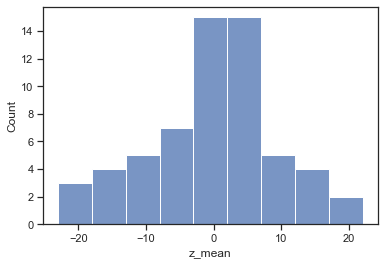

In [8]:
_, nbins = knuth_bin_width(table_repr_pt['z_median'], return_bins=True)
sns.histplot(data=table_repr_pt, x=('z_mean'), bins=nbins, binwidth=5)

In [9]:
table_repr_new = pd.read_excel('table_repr.xlsx')
table_repr_rt = run_table(table_repr_new)

(<Figure size 720x864 with 3 Axes>,
 <AxesSubplot:title={'center':'Table Data: Interquartile Range 50% vs Run Nr'}, xlabel='Run Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

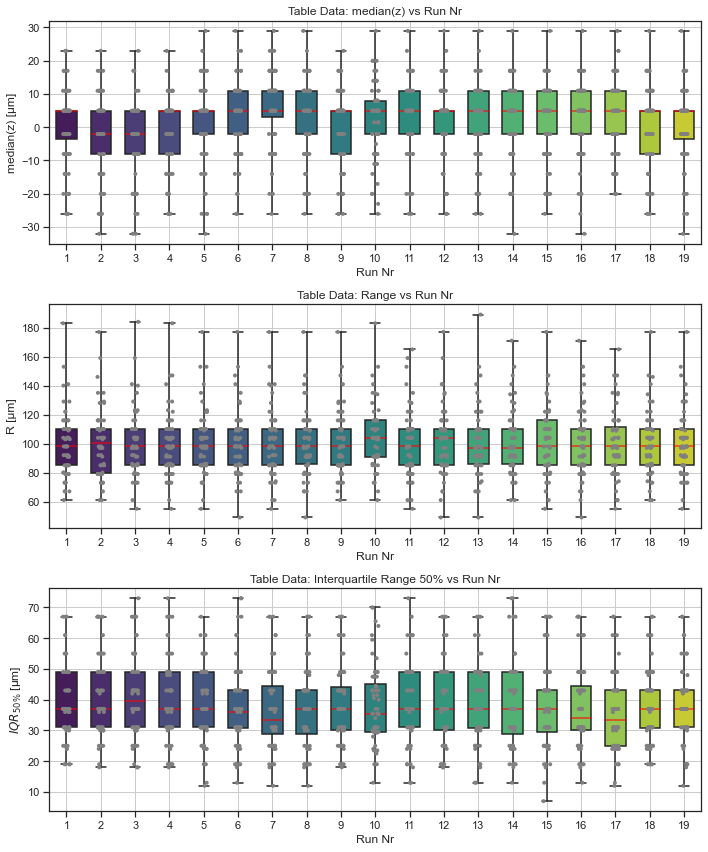

In [10]:
plot_mean_iqr_range_per_point(table_repr_rt, measurement_subject_title='Table')
# plt.savefig(Path('.') / "MSA" / "MSA_Plots" / "Table" / f"Table_Data_Raw_Summary_RunNr")

(<Figure size 1296x1008 with 3 Axes>,
 <AxesSubplot:title={'center':'Table Data: Interquartile Range 50% vs Point Nr'}, xlabel='Point Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

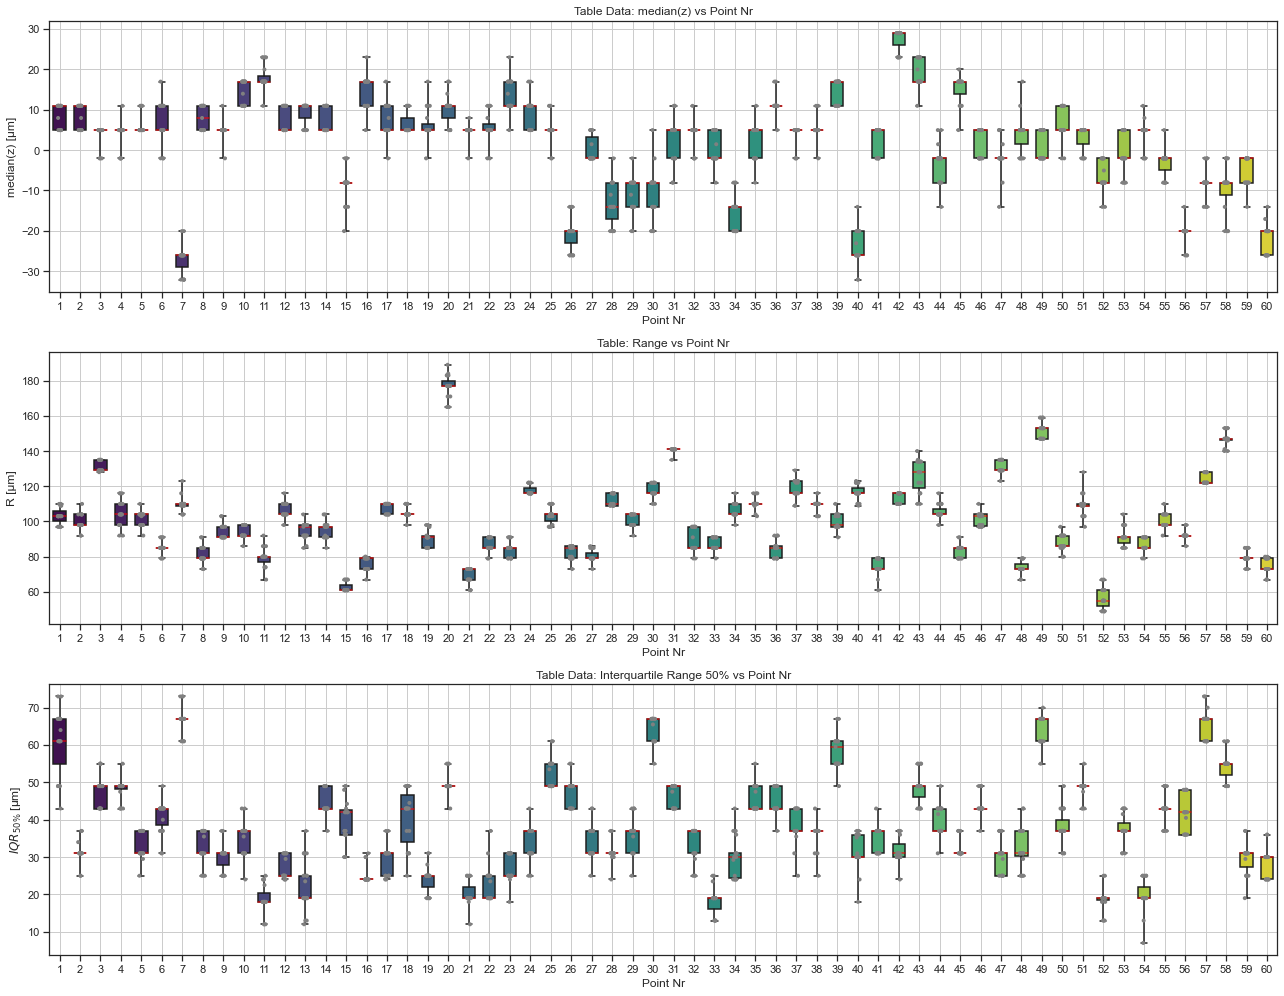

In [11]:
plot_mean_iqr_range_per_run(table_repr_rt, measurement_subject_title='Table')
# plt.savefig(Path('.') / "MSA" / "MSA_Plots" / "Table" / f"Table_Data_Raw_Summary_PointNr")

[Text(0, 0.5, 'z [µm]')]

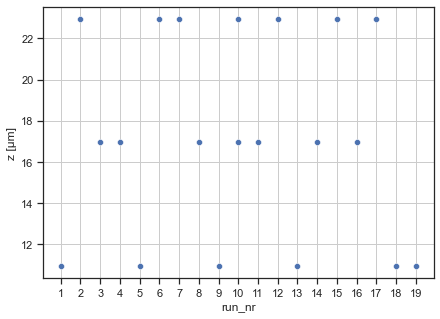

In [12]:
f, ax = plt.subplots(figsize=(7, 5))
data = table_repr.query('point==1').query('x==4.68 & y==4.49')
# data = table_repr.query('point==1').query('x==4.49 & y==4.68')
# data = table_repr.query('point==1').query('x==4.24 & y==4.24')
# data = table_repr.query('point==1').query('x==4.74 & y==4.24')
# data = table_repr.query('point==1').query('x==4.24 & y==4.74')
sns.scatterplot(x="run_nr", y="z", data=data,)
ax.set_xticks(range(1,20,1))

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="z [µm]")

# Lao

In [13]:
from pathlib import Path
file_path = Path('.') / 'MSA' / '20211014_msa_rep_1t_lao_repetitions.csv'
lao_repr_original = pd.read_csv(file_path, delimiter=';', decimal=',', header=1, names=['run_nr','hex_nr','point','x','y' ,'z'])
lao_repr = lao_repr_original

In [14]:
mean_lao_all = np.mean(lao_repr['z'])
lao_repr['z'] = lao_repr['z'].apply(lambda x: (x-mean_lao_all)*1e3)

In [15]:
lao_repr

,run_nr,hex_nr,point,x,y,z
0,1,1,1,4.74,4.24,27.56119
1,1,1,1,4.68,4.49,-15.43881
2,1,1,1,4.49,4.68,27.56119
3,1,1,1,4.24,4.74,27.56119
4,1,1,1,3.99,4.68,27.56119
...,...,...,...,...,...,...
15594,19,1,60,25.65,-7.24,3.56119
15595,19,1,60,25.83,-7.42,-33.43881
15596,19,1,60,26.08,-7.49,33.56119
15597,19,1,60,26.33,-7.42,21.56119


In [16]:
# measurement_distribution_per_point_series(lao_repr, measurement_subject_title='Lao')

Note: vorher war hier immer median jetzt bin ich immer beim mean

<AxesSubplot:xlabel='z_median', ylabel='Count'>

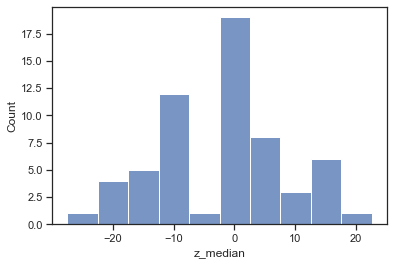

In [17]:
lao_repr_pt = pivot_table_data_old(lao_repr)
_, nbins = knuth_bin_width(lao_repr_pt['z_median'], return_bins=True)
sns.histplot(data=lao_repr_pt, x=('z_median'), bins=nbins, binwidth=5)

In [18]:
lao_repr_rt = run_table(lao_repr_original)

(<Figure size 720x864 with 3 Axes>,
 <AxesSubplot:title={'center':'Lao Data: Interquartile Range 50% vs Run Nr'}, xlabel='Run Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

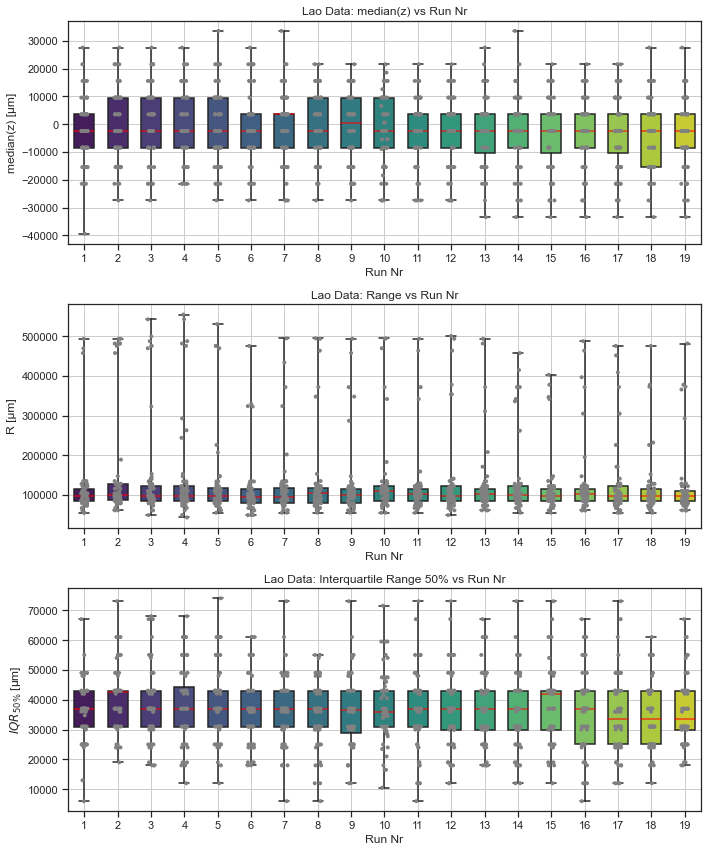

In [19]:
plot_mean_iqr_range_per_point(lao_repr_rt, measurement_subject_title='Lao')

[Text(0, 0.5, 'z [µm]')]

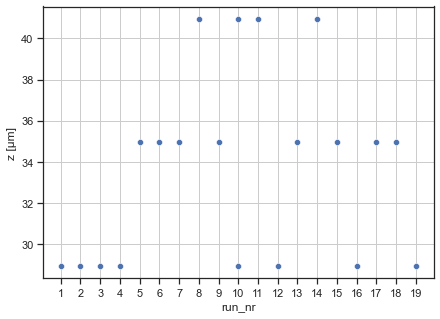

In [20]:
f, ax = plt.subplots(figsize=(7, 5))
# data = lao_repr.query('point==1').query('x==4.68 & y==4.49')
# data = table_repr.query('point==1').query('x==4.49 & y==4.68')
data = table_repr.query('point==1').query('x==4.24 & y==4.24')
# data = table_repr.query('point==1').query('x==4.74 & y==4.24')
# data = table_repr.query('point==1').query('x==4.24 & y==4.74')

sns.scatterplot(x="run_nr", y="z", data=data,)
ax.set_xticks(range(1,20,1))

# Add in points to show each observation
# sns.stripplot(x="point", y="z", data=data,
#               size=4, color=".3", linewidth=0,)
#                palette='viridis')
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="z [µm]")

(<Figure size 1296x1008 with 3 Axes>,
 <AxesSubplot:title={'center':'Lao Data: Interquartile Range 50% vs Point Nr'}, xlabel='Point Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

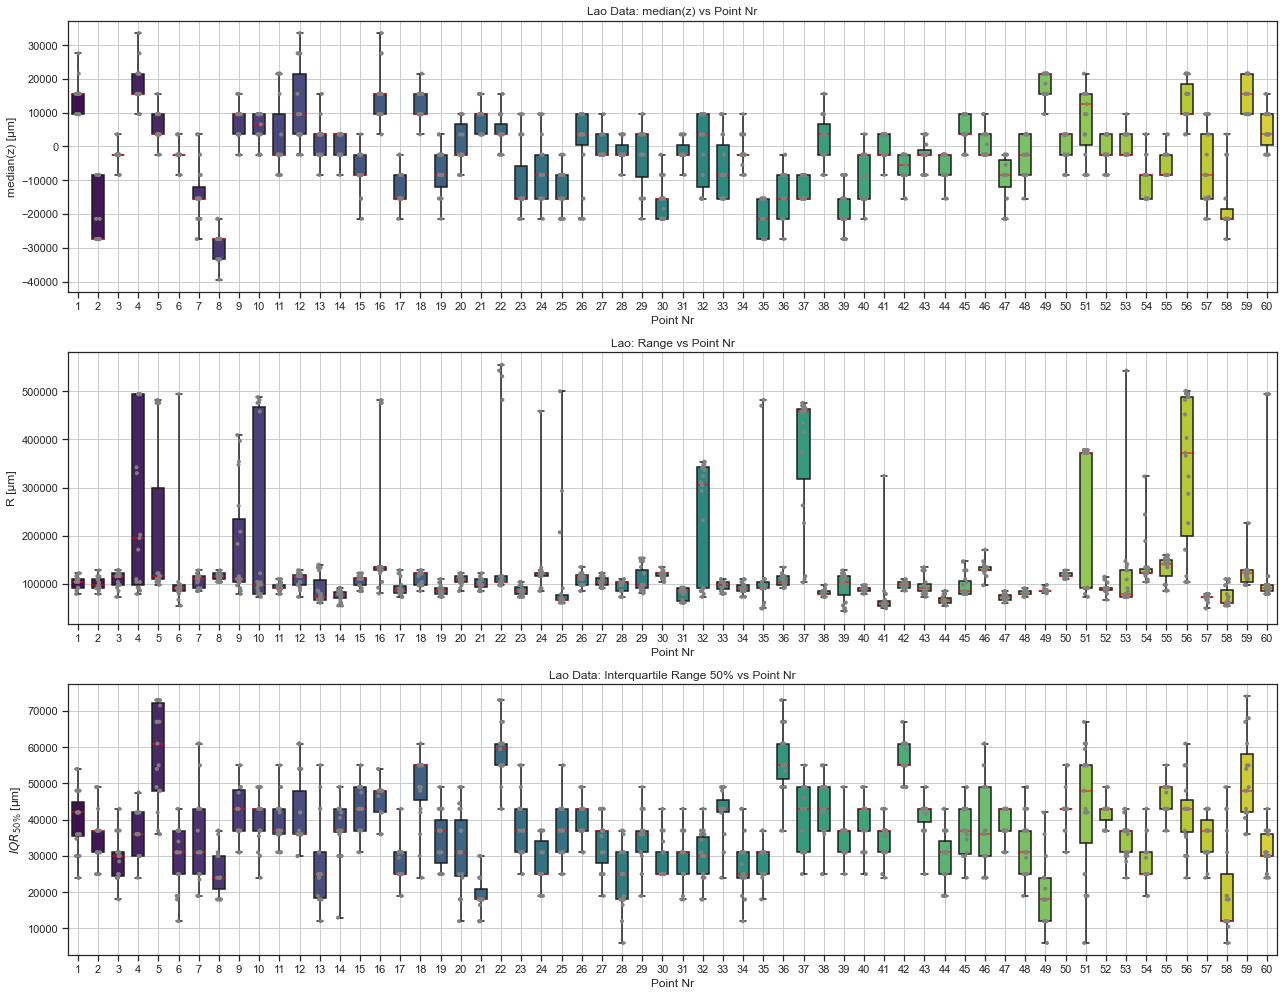

In [21]:
plot_mean_iqr_range_per_run(lao_repr_rt, measurement_subject_title='Lao')

# Steel

In [22]:
from pathlib import Path
file_path = Path('.') / 'MSA' / '20211014_msa_rep_1t_steel_repetitions.csv'
steel_repr = pd.read_csv(file_path, delimiter=';', decimal=',', header=1, names=['run_nr','hex_nr','point','x','y' ,'z'])
steel_repr_original = steel_repr

In [23]:
mean_steel_all = np.mean(steel_repr['z'])
steel_repr['z'] = steel_repr['z'].apply(lambda x: (x-mean_steel_all)*1e3)

In [24]:
# measurement_distribution_per_point_series(steel_repr, measurement_subject_title='Steel')

<AxesSubplot:xlabel='z_median', ylabel='Count'>

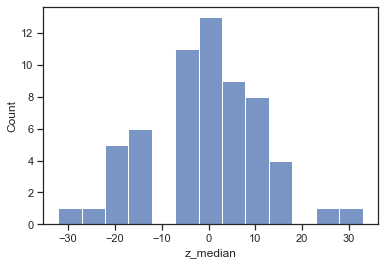

In [25]:
steel_repr_pt = pivot_table_data_old(steel_repr)
_, nbins = knuth_bin_width(steel_repr_pt['z_median'], return_bins=True)
sns.histplot(data=steel_repr_pt, x=('z_median'), bins=nbins, binwidth=5)

In [26]:
steel_repr_rt = run_table(steel_repr)

(<Figure size 720x864 with 3 Axes>,
 <AxesSubplot:title={'center':'Steel Data: Interquartile Range 50% vs Run Nr'}, xlabel='Run Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

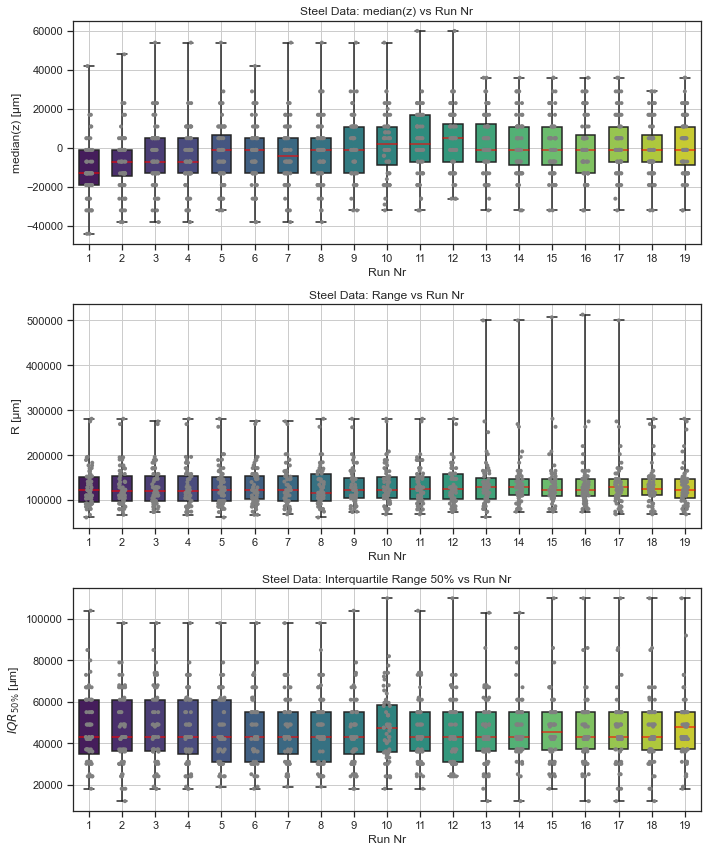

In [27]:
plot_mean_iqr_range_per_point(steel_repr_rt, measurement_subject_title='Steel')

NameError: name 'p' is not defined

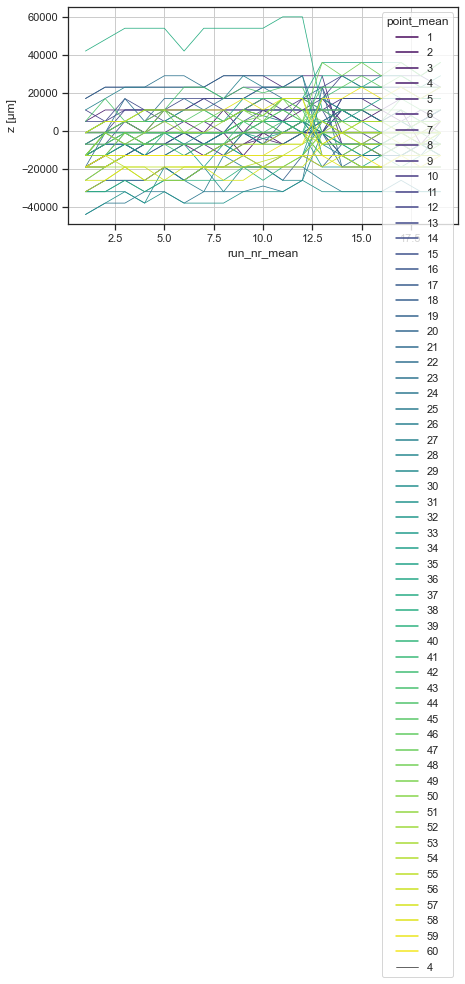

In [28]:
# fig, *axes = plt.subplots(figsize=(10,12), nrows=3, ncols=1)

modes = [('z_median'),('z_ptp'),('z_find_iqr')]
data = steel_repr_rt

f, ax = plt.subplots(figsize=(7, 4), ncols=1, nrows=1)
    # Plot the orbital period with horizontal boxes

steel_repr_rt[('point_mean')] = [f"{int(x)}" for x in steel_repr_rt[('point_mean')]]
sns.lineplot(x=('run_nr_mean'), y=modes[0], data=steel_repr_rt,
            size=4, color=".5", linewidth=0, ax=ax, ci=None, hue=('point_mean'),
            palette='viridis')

        # Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="z [µm]")
ax.set_title(f'Point {p} Raw Data Steel')
plt.tight_layout()
ax.get_legend().remove()
ax.set_xticks(range(1,20,1))
ax.set_xlabel('Run Nr')

(<Figure size 1296x1008 with 3 Axes>,
 <AxesSubplot:title={'center':'Steel Data: Interquartile Range 50% vs Point Nr'}, xlabel='Point Nr', ylabel='$IQR_{50\\%}$ [µm]'>)

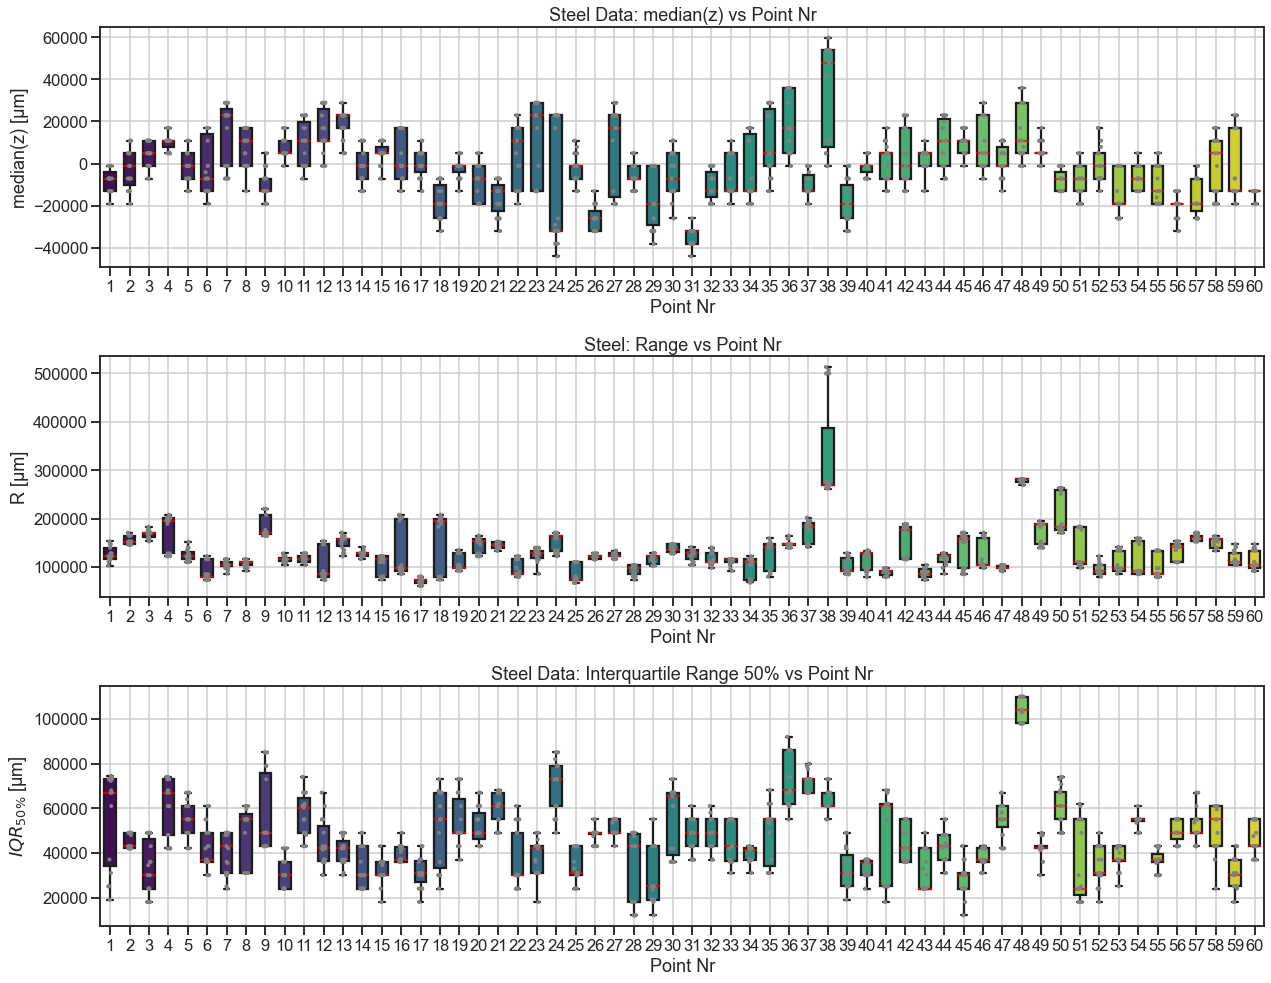

In [ ]:
plot_mean_iqr_range_per_run(steel_repr_rt, measurement_subject_title='Steel')

# Lao over night + no light 18.10.21 - old

In [ ]:
from pathlib import Path
file_path = Path('.') / 'MSA' / '20211018_msa_rep_1t_lao_night.txt'
lao_repr_night = tdu.read_measurement_csv(file_path)
mean_lao_night_all = np.mean(lao_repr_night['z'])
lao_repr_night['z'] = lao_repr_night['z'].apply(lambda z: (z-mean_lao_night_all)*1e3)
lao_repr_night

,run_nr,hex_nr,point,x,y,z,unix_time
0,1,1,1,4.68,4.49,12.240491,1634566543
1,1,1,1,4.49,4.68,-5.759509,1634566543
2,1,1,1,4.24,4.74,0.240491,1634566543
3,1,1,1,3.99,4.68,36.240491,1634566544
4,1,1,1,3.81,4.49,-36.759509,1634566544
...,...,...,...,...,...,...,...
116993,150,1,60,25.65,-7.24,-54.759509,1634620679
116994,150,1,60,25.83,-7.42,-30.759509,1634620680
116995,150,1,60,26.08,-7.49,-11.759509,1634620680
116996,150,1,60,26.33,-7.42,-17.759509,1634620681


In [ ]:
lao_repr_night_rt = run_table_time(lao_repr_night)
lao_repr_night_rt

NameError: name 'run_table_time' is not defined

In [ ]:
lao_repr_night_rt['date'][0].isoformat()

'2021-10-18T16:15:44+02:00'

### 60 plots for each point one plot to monitor its stabilty.

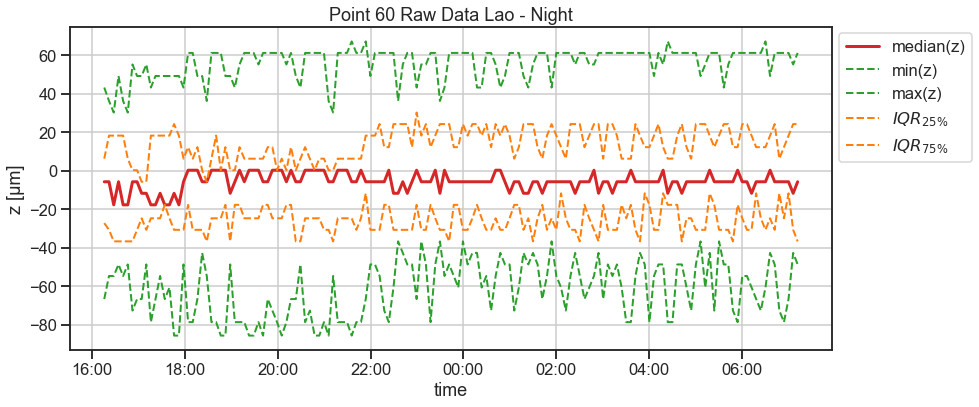

In [ ]:
%matplotlib inline
sns.set_theme(style="ticks")
sns.set_context("talk")
#? Just loop over the function to create all 60 plots for each point
# for p in range(1,61,1):
plot_point_evolution(lao_repr_night_rt.query(f'point=={1}'))


# Lao 1 point night 20.10.2021 - old

In [3]:
lao_1p_night = tdu.read_single_measurement('MSA', '20211020_msa_1point_lao_night.txt')
lao_1p_night = tdu.df_convert_unix_to_datetime(lao_1p_night)

In [4]:
lao_1p_night

,run_nr,hex_nr,point,x,y,z,datetime
0,1,1,24,-17.32,-10.0,-157.353,2021-10-20 16:27:49+02:00
1,1,1,24,-17.32,-10.0,-157.359,2021-10-20 16:27:49+02:00
2,1,1,24,-17.32,-10.0,-157.347,2021-10-20 16:27:49+02:00
3,1,1,24,-17.32,-10.0,-157.353,2021-10-20 16:27:50+02:00
4,1,1,24,-17.32,-10.0,-157.365,2021-10-20 16:27:50+02:00
...,...,...,...,...,...,...,...
239993,240,1,24,-17.32,-10.0,-157.365,2021-10-21 07:57:04+02:00
239994,240,1,24,-17.32,-10.0,-157.365,2021-10-21 07:57:05+02:00
239995,240,1,24,-17.32,-10.0,-157.365,2021-10-21 07:57:05+02:00
239996,240,1,24,-17.32,-10.0,-157.365,2021-10-21 07:57:05+02:00


In [5]:
mean_1p_night = np.mean(lao_1p_night['z'])
lao_1p_night['z'] = lao_1p_night['z'].apply(lambda x: (x-mean_1p_night) *1e3) 

In [6]:
lao_1p_night

,run_nr,hex_nr,point,x,y,z,datetime
0,1,1,24,-17.32,-10.0,-0.388028,2021-10-20 16:27:49+02:00
1,1,1,24,-17.32,-10.0,-6.388028,2021-10-20 16:27:49+02:00
2,1,1,24,-17.32,-10.0,5.611972,2021-10-20 16:27:49+02:00
3,1,1,24,-17.32,-10.0,-0.388028,2021-10-20 16:27:50+02:00
4,1,1,24,-17.32,-10.0,-12.388028,2021-10-20 16:27:50+02:00
...,...,...,...,...,...,...,...
239993,240,1,24,-17.32,-10.0,-12.388028,2021-10-21 07:57:04+02:00
239994,240,1,24,-17.32,-10.0,-12.388028,2021-10-21 07:57:05+02:00
239995,240,1,24,-17.32,-10.0,-12.388028,2021-10-21 07:57:05+02:00
239996,240,1,24,-17.32,-10.0,-12.388028,2021-10-21 07:57:05+02:00


(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

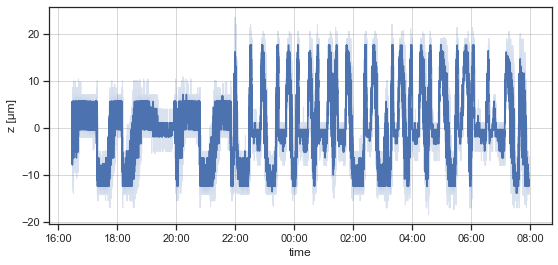

In [7]:
tdp.plot_data_vs_time(lao_1p_night)

In [8]:
from datetime import datetime
shift_time = datetime(2021, 10, 20, hour=21, minute=48)
shift_time = local_tz.localize(shift_time) # translate to local timezone -> correct format + obj type

before_shift_df = lao_1p_night[lao_1p_night.datetime < shift_time]
after_shift_df = lao_1p_night[lao_1p_night.datetime > shift_time]

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

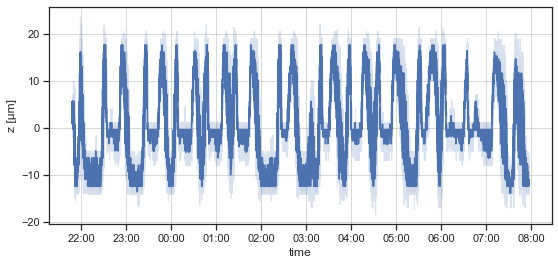

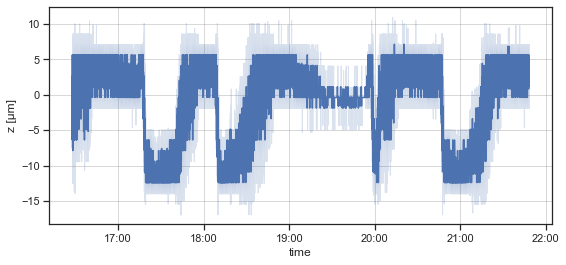

In [9]:
%matplotlib inline
tdp.plot_data_vs_time(after_shift_df)
tdp.plot_data_vs_time(before_shift_df)

In [10]:
# #_, nbins = knuth_bin_width(steel_cap['z'], return_bins=True)
# fig, ax = tdp.ts_hist(before_shift_df, bins=nbins)
# plt.grid(c="grey", ls="-", lw=1, alpha=0.3)
# ax1 = plt.gca()
# _, ax2 = tdp.ts_hist(after_shift_df, bins=nbins, color_gauss='tab:orange', color_plot='tab:orange')


In [11]:
def plot_two_dists(data1, data2): 

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(7,6), nrows=1, ncols=1)

    nbins = np.array(range(-20,26,6)) -0.5
    _, label = tdp.hist_label_data(data1['z'])
    sns.histplot(data1['z'],bins=nbins, kde=False, ax=ax, element='step', color='tab:blue', stat='probability', label=label, fill=True, alpha=0.4)
    tdp.normal(data1['z'].mean(), data1['z'].std(), histmax=ax.get_ylim()[1], color='tab:blue')
        
    _, label = tdp.hist_label_data(data2['z'])
    nbins = np.array(range(-20,26,6)) -0.5
    sns.histplot(data2['z'],bins=nbins, kde=False, ax=ax, element='step', color='tab:orange', stat='probability', label=label, fill=True, alpha=0.4)
    tdp.normal(data2['z'].mean(), data2['z'].std(), histmax=ax.get_ylim()[1], color='tab:orange')

    plt.grid(c="grey", ls="-", lw=1, alpha=0.5)
    ax.set_xlabel('z [µm]')
    plt.legend(bbox_to_anchor=(1, 1), loc='best', borderaxespad=0.4)
    return fig, ax

# Lao 1 point Random walk

In [12]:
lao_1pR_night = tdu.read_single_measurement('MSA', '20211021_msa_1pRandom_lao_night.txt')
lao_1pR_night = lao_1pR_night.query('x==-17.32 & y==-10.0') #? Filter for point of interest
lao_1pR_night = tdu.df_convert_unix_to_datetime(lao_1pR_night)

In [13]:
mean_1pR_night = np.median(lao_1pR_night['z'])
lao_1pR_night['z'] = lao_1pR_night['z'].apply(lambda x: (x-mean_1pR_night) *1e3) 

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

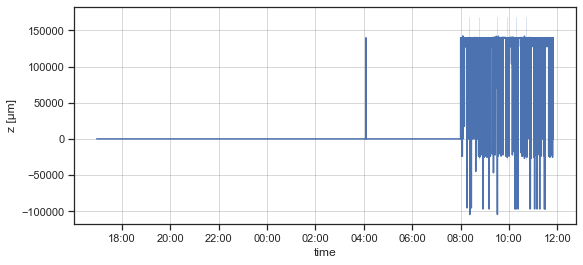

In [14]:
%matplotlib inline
tdp.plot_data_vs_time(lao_1pR_night)

split data into clean and problematic

In [15]:
from datetime import datetime
shift_time = datetime(2021, 10, 22, hour=8, minute=0)
shift_time = local_tz.localize(shift_time) #* translate to local timezone -> correct format + obj type
print(shift_time)
before_shift_df_random = lao_1pR_night[lao_1pR_night.datetime < shift_time]
after_shift_df_random = lao_1pR_night[lao_1pR_night.datetime > shift_time]

2021-10-22 08:00:00+02:00


In [16]:
%matplotlib inline

mid_shift_time = datetime(2021, 10, 21, hour=21, minute=34)
mid_shift_time = local_tz.localize(mid_shift_time) #* translate to local timezone -> correct format + obj type

before_random = before_shift_df_random[lao_1pR_night.datetime < mid_shift_time].query('-40<z<40')
after_random = before_shift_df_random[lao_1pR_night.datetime > mid_shift_time].query('-40<z<40')

C:\Users\Domin\AppData\Local\Temp/ipykernel_3716/590678085.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  before_random = before_shift_df_random[lao_1pR_night.datetime < mid_shift_time].query('-40<z<40')
C:\Users\Domin\AppData\Local\Temp/ipykernel_3716/590678085.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after_random = before_shift_df_random[lao_1pR_night.datetime > mid_shift_time].query('-40<z<40')


(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

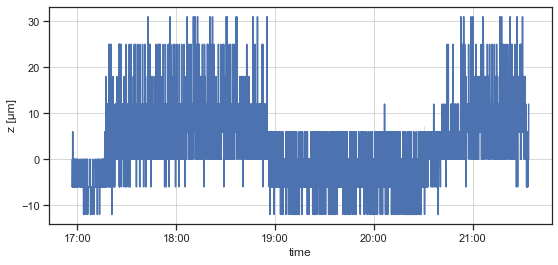

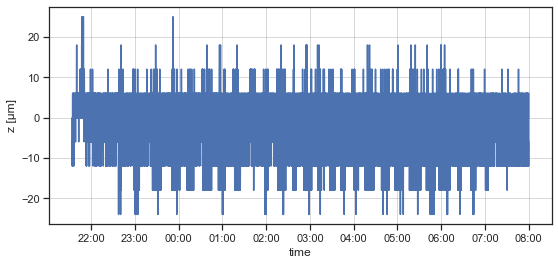

In [17]:
tdp.plot_data_vs_time(before_random)
tdp.plot_data_vs_time(after_random)

(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:xlabel='z [µm]', ylabel='Probability'>)

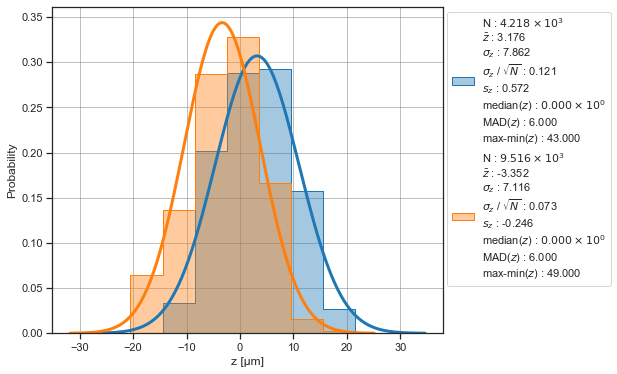

In [18]:
plot_two_dists(before_random, after_random)

# Lao 1 point lights on - old 27-10-2021

In [19]:
lao_light = tdu.read_single_measurement('MSA', '20211027_msa_1point_lao_night_light_on.txt')
lao_light = tdu.df_convert_unix_to_datetime(lao_light)

In [20]:
mean_light = np.median(lao_light['z'])
lao_light['z'] = lao_light['z'].apply(lambda x: (x-mean_light) *1e3) 

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

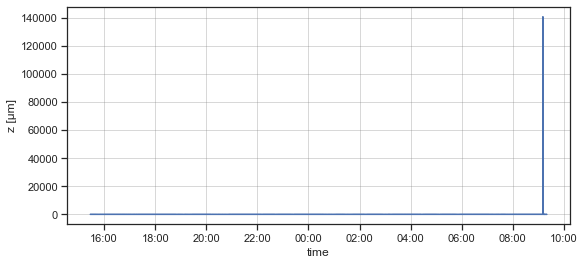

In [21]:
tdp.plot_data_vs_time(lao_light)

In [22]:
lao_light.query('z<100', inplace=True)

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

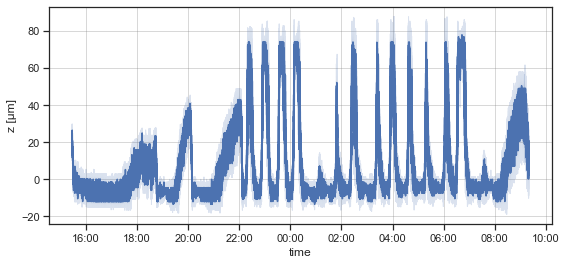

In [23]:
tdp.plot_data_vs_time(lao_light)

(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:xlabel='z [µm]', ylabel='Probability'>)

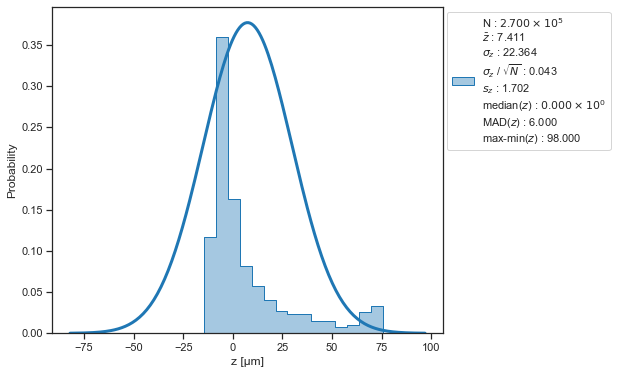

In [24]:
nbins = np.array(range(-80,80,6)) -0.5

tdp.ts_hist(lao_light, bins=nbins)

# lao lightswitch causalty - nachtschicht 18-11-2021

In [2]:
lao_cause = tdu.read_single_measurement('MSA', '20211118_lao_light_causality.txt')
lao_cause = tdu.df_convert_unix_to_datetime(lao_cause) 

mean_cause = np.mean(lao_cause['z'])
lao_cause['z'] = lao_cause['z'].apply(lambda x: (x-mean_cause) *1e3) 

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='z [µm]'>)

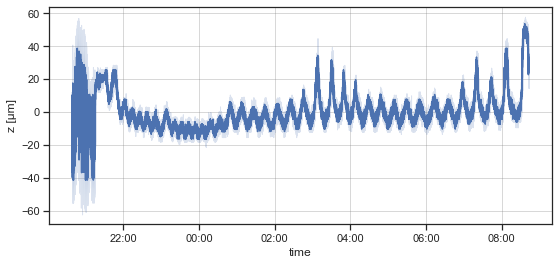

In [3]:
tdp.plot_data_vs_time(lao_cause)

In [5]:
special_times = {
'd_phase_1': '20:42:00 18-11-2021',
'l_phase_1': '22:42:00 18-11-2021',
'd_phase_2': '01:45:00 19-11-2021',
'l_phase_2': '04:43:00 19-11-2021',
'd_phase_3': '07:45:00 19-11-2021',}
special_times = tdu.dict_date_to_datetime(special_times)

import datetime
sunrise = '07:53:00 19-11-2021'
sunrise = datetime.datetime.strptime(sunrise, '%H:%M:%S %d-%m-%Y')
sunrise = local_tz.localize(sunrise)

In [5]:
import datetime
special_times = {key: datetime.datetime.strptime(val, '%H:%M:%S %d-%m-%Y') for key, val in special_times.items()}
special_times = {key: local_tz.localize(val) for key, val in special_times.items()}

In [6]:
special_times

{'d_phase_1': datetime.datetime(2021, 11, 18, 20, 42, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'l_phase_1': datetime.datetime(2021, 11, 18, 22, 42, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'd_phase_2': datetime.datetime(2021, 11, 19, 1, 45, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'l_phase_2': datetime.datetime(2021, 11, 19, 4, 43, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'd_phase_3': datetime.datetime(2021, 11, 19, 7, 45, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>)}

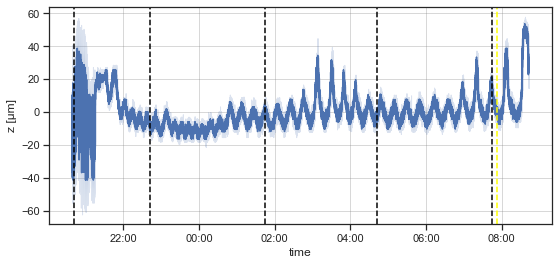

In [7]:
tdp.plot_data_vs_time(lao_cause)
ax = plt.gca()
for t in special_times.values():
    ax.axvline(x=t, c='black', ls='--')
ax.axvline(sunrise, c='yellow', ls='--')

## Temperature information

In [8]:
from pathlib import Path
db_path = Path('.') / 'MSA' / 'Logger_MADMAX.db'
lao_cause_temp = tdu.query_temps_from_db(db_path,'2021-11-18 20:38:51', '2021-11-19 08:44:00')
lao_cause_temp = tdu.add_column_time_passed(lao_cause_temp)
#! Fan speed war bei 0

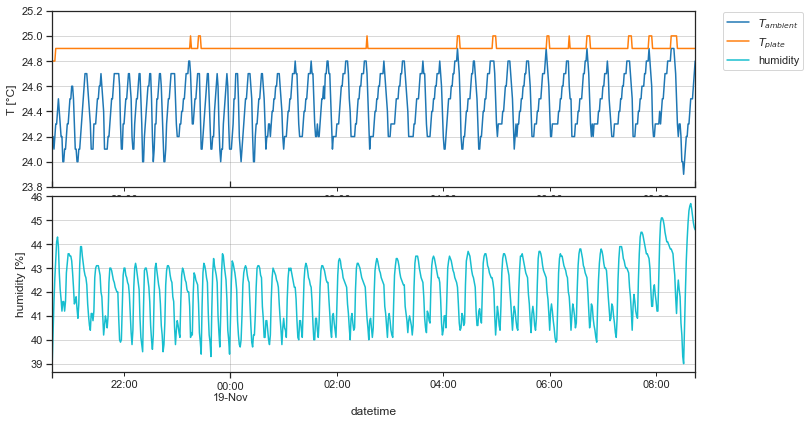

In [9]:
fig, (ax_t,ax_h) = plt.subplots(figsize=(10,6), nrows=2, ncols=1)
l1 = lao_cause_temp.plot(x="datetime", y="T_ambient", legend=False, ax=ax_t, label="$T_{ambient}$", c='tab:blue')
l2 = lao_cause_temp.plot(x="datetime", y="T_plate", ax=ax_t, legend=False, label="$T_{plate}$", color="tab:orange")
l3 = lao_cause_temp.plot(x="datetime", y="humidity", ax=ax_h, legend=False, label="humidity", color="tab:cyan")

ax_t.set_ylim(23.8, 25.2)
ax_t.set_xticklabels([])
ax_t.set_xlabel('')
ax_t.tick_params(axis="x",direction="in", pad=-15)
ax_t.set_ylabel("T [°C]")
ax_t.grid(c="grey", ls="-", lw=1, alpha=0.3)

ax_h.grid(c="grey", ls="-", lw=1, alpha=0.3)
ax_h.set_ylabel("humidity [%]")

fig.tight_layout(h_pad=-1)
fig.legend(bbox_to_anchor=(1.14, 0.9), loc='right')

interpolate humidity

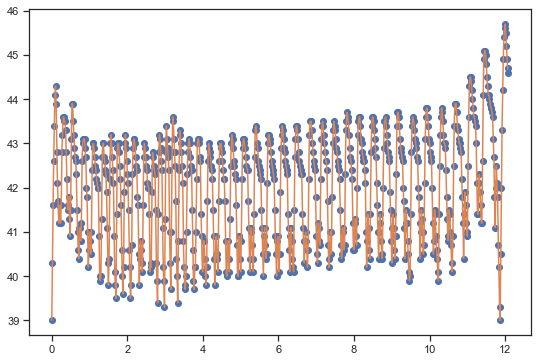

In [14]:
from scipy import interpolate
x = lao_cause_temp['time_h']
y = lao_cause_temp['humidity']
f = interpolate.interp1d(x,y, kind='linear', fill_value="extrapolate")


lao_cause['humidity'] = y_new
fig, ax = plt.subplots(figsize=(9,6), nrows=1, ncols=1)
ax.plot(x, y, 'o', x_new, y_new, '-')
plt.show()

Interpolate temp peaks

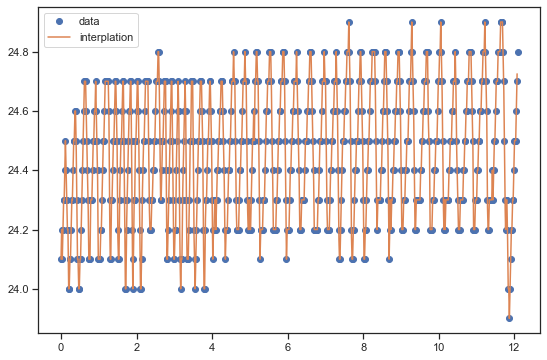

In [15]:
from scipy import interpolate
x = lao_cause_temp['time_h']
y = lao_cause_temp['T_ambient']
f = interpolate.interp1d(x,y, kind='linear', fill_value="extrapolate")

x_new = lao_cause['time_h']
y_new = f(x_new)
lao_cause['T_ambient'] = y_new

fig, ax = plt.subplots(figsize=(9,6), nrows=1, ncols=1)
ax.plot(x, y, 'o', label='data',  )
ax.plot(x_new, y_new, '-', label='interplation',   )
plt.legend()
plt.show()

### find temp peaks

[  1785   5766   9747  14104  18561  22120  25160  28203  30990  34671
  39373  42031  44690  47348  50137  52921  56477  60157  64853  69682
  74251  77806  78951  84414  89747  95079 100664 106251 111078 116160
 120859 126066 130892 136226 141559 147655 153242 159083 165047 171018
 174061 177741]


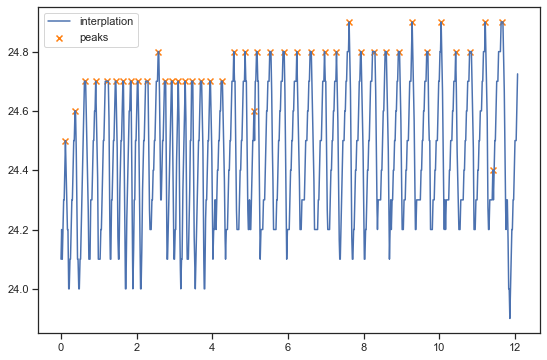

In [16]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(y_new, height=24.4 )
print(peaks)
fig, ax = plt.subplots(figsize=(9,6), nrows=1, ncols=1)
ax.plot(x_new, y_new, '-', label='interplation' )
ax.scatter(x_new[peaks], y_new[peaks], marker='x', label="peaks", color='tab:orange')
plt.legend()
plt.show()

### find z peaks

In [17]:
lao_cause = tdu.add_column_time_passed(lao_cause)

[     2      6      8 ... 184006 184012 184016]


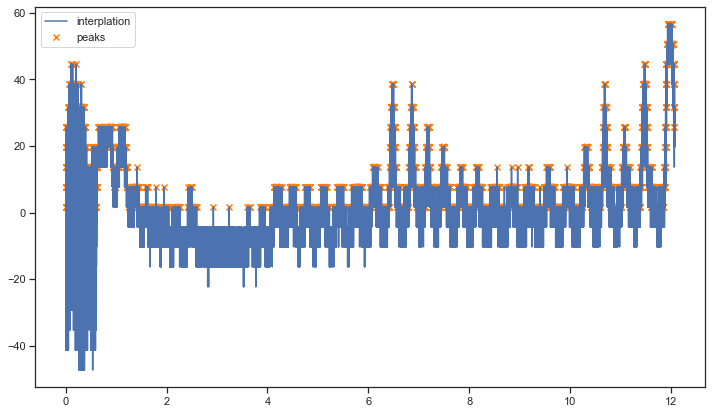

In [18]:
from scipy.signal import find_peaks
t = lao_cause['time_h']
z_vals = lao_cause['z']
peaks, _ = find_peaks(z_vals, height=0 )
print(peaks)
fig, ax = plt.subplots(figsize=(12,7), nrows=1, ncols=1)
ax.plot(t, z_vals, '-', label='interplation' )
ax.scatter(t[peaks], z_vals[peaks], marker='x', label="peaks", color='tab:orange')
plt.legend()
plt.show()

Text(0, 0.5, 'Temp_peaks')

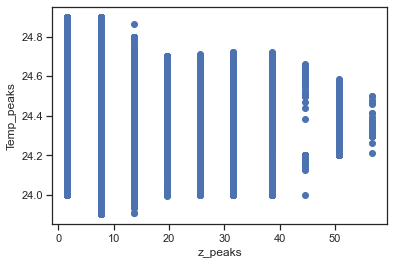

In [19]:
plt.scatter(z_vals[peaks], y_new[peaks])
plt.xlabel('z_peaks')
plt.ylabel('Temp_peaks')

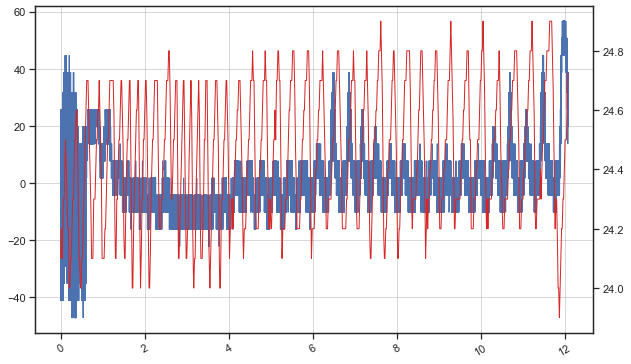

In [20]:
fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
ax.plot(lao_cause['time_h'], lao_cause['z'], lw=1, zorder=5, label='z')
plt.grid('both', c="grey", ls="-", lw=1, alpha=0.3)
plt.xticks(rotation=30)
ax2 = ax.twinx()
# ax2.plot(lao_cause['time'], lao_cause['humidity'], color='tab:orange',lw=1, zorder=0, label='humidity')
ax2.plot(lao_cause['time_h'], lao_cause['T_ambient'], color='tab:red',lw=1, zorder=0)
plt.show()
# plt.scatter(y_new, lao_cause['z'])

# Lao fanspeed

In [21]:
lao_fan = tdu.read_single_measurement('MSA', '20211125_lao_fanspeed.txt')
lao_fan = tdu.df_convert_unix_to_datetime(lao_fan)

In [22]:
mean_fan = np.mean(lao_fan['z'])
lao_fan['z'] = lao_fan['z'].apply(lambda x: (x-mean_fan) *1e3) 

In [23]:
special_times_fan = {'d_phase_1': '14:35:00 25-11-2021',
                    'l_phase_1': '15:21:00 25-11-2021',}

special_times_fan = tdu.dict_date_to_datetime(special_times_fan)

In [24]:
special_times_fan

{'d_phase_1': datetime.datetime(2021, 11, 25, 14, 35, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'l_phase_1': datetime.datetime(2021, 11, 25, 15, 21, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>)}

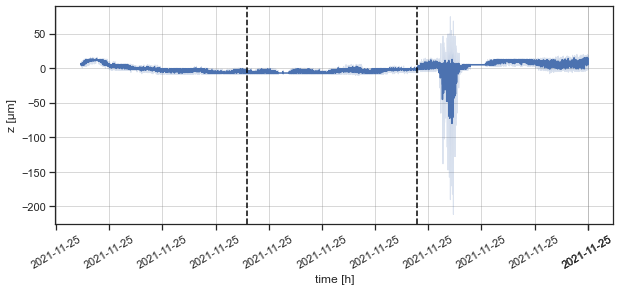

In [26]:
%matplotlib inline
fig, ax = plt.subplots( figsize=(10, 4), ncols=1, nrows=1)
sns.lineplot(x='datetime', y='z', data=lao_fan, ci='sd')
plt.grid(c="grey", ls="-", lw=1, alpha=0.3)
plt.xlabel('time [h]')
plt.ylabel('z [µm]')
plt.xlabel('time [h]')
plt.ylabel('z [µm]')
N = 12
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, N), 2))
plt.xticks(rotation=30)
ax = plt.gca()
# ax.axvline(x='01:43:05', c='black', ls='--')
# ax.get_legend().remove()
for t in special_times_fan.values():
    ax.axvline(x=t, c='black', ls='--')

In [27]:
from pathlib import Path
db_path = Path('.') / 'MSA' / 'Logger_MADMAX.db'
lao_fan_temp = tdu.query_temps_from_db(db_path,'2021-11-25 13:49:00', '2021-11-25 16:07:00')
lao_fan_temp = tdu.add_column_time_passed(lao_fan_temp)

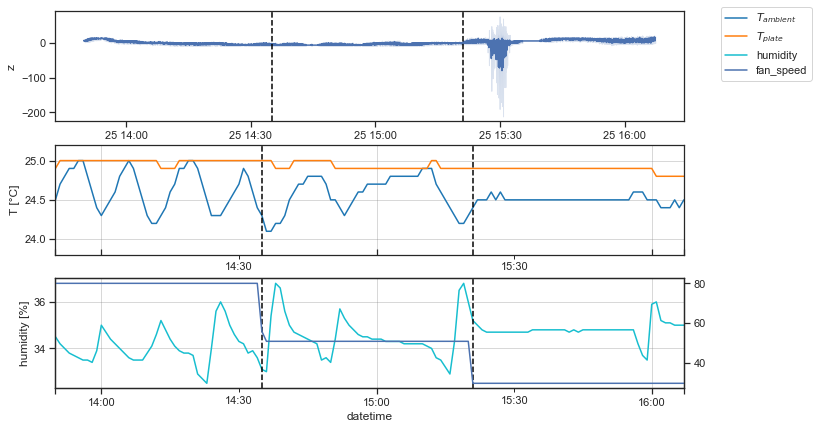

In [30]:
fig, (ax_z, ax_t,ax_h) = plt.subplots(figsize=(10,6), nrows=3, ncols=1)
sns.lineplot(x='datetime', y='z', data=lao_fan, ci='sd', ax=ax_z)



l1 = lao_fan_temp.plot(x="datetime", y="T_ambient", legend=False, ax=ax_t, label="$T_{ambient}$", c='tab:blue')
l2 = lao_fan_temp.plot(x="datetime", y="T_plate", ax=ax_t, legend=False, label="$T_{plate}$", color="tab:orange")
l3 = lao_fan_temp.plot(x="datetime", y="humidity", ax=ax_h, legend=False, label="humidity", color="tab:cyan")
ax_fan = ax_h.twinx()
l4 = lao_fan_temp.plot(x="datetime", y="fan_speed", ax=ax_fan, legend=False, label="fan_speed")

ax_t.set_ylim(23.8, 25.2)
ax_t.set_xticklabels([])
ax_t.set_xlabel('')
ax_t.tick_params(axis="x",direction="in", pad=-15)
ax_t.set_ylabel("T [°C]")
ax_t.grid(c="grey", ls="-", lw=1, alpha=0.3)

ax_h.grid(c="grey", ls="-", lw=1, alpha=0.3)
ax_h.set_ylabel("humidity [%]")

for ax in (ax_z,ax_t,ax_h):
    for t in special_times_fan.values():
        ax.axvline(x=t, c='black', ls='--')   
        
fig.tight_layout(h_pad=-1)
fig.legend(bbox_to_anchor=(1.14, 0.9), loc='right')